<a href="https://colab.research.google.com/github/zhaoxin1124ds/Shill-bidding-detection-/blob/main/Unsupervised_learning_Shill_Bidding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shill Bidding labeling using unsupervised learning

## Introduction

Although shill bidding is a common auction fraud, it is however very tough to detect. The challenge is that the behavior of fraud bidders could be very similar to normal bidders. In this research project, I will implement an unsupervised learning algorithm for clustering and labeling of shill bidding using real business data.

The **challenge** of this experiment is the records whose present obvious features on normal or shill biddings. I labeled those data as 'suspicious' and used supervised classification to further split the 'suspicious' records. The training data for supervised classification were those clearly labeled normal and shill bidding records.

The data is real auction records from eBay, and is downloaded from [UCI](https://archive.ics.uci.edu/ml/datasets/Shill+Bidding+Dataset).

The data includes 13 variables:
Record ID: Unique identifier of a record in the dataset:
* Auction ID: Unique identifier of an auction.
* Bidder ID: Unique identifier of a bidder.
* Bidder Tendency: A shill bidder participates exclusively in auctions of few sellers rather than a diversified lot. This is a collusive act involving the fraudulent seller and an accomplice.
* Bidding Ratio: A shill bidder participates more frequently to raise the * auction price and attract higher bids from legitimate participants.
Successive Outbidding: A shill bidder successively outbids himself even though he is the current winner to increase the price gradually with small consecutive increments.
* Last Bidding: A shill bidder becomes inactive at the last stage of the auction (more than 90\% of the auction duration) to avoid winning the auction.
* Auction Bids: Auctions with SB activities tend to have a much higher number of bids than the average of bids in concurrent auctions.
* Auction Starting Price: a shill bidder usually offers a small starting price to attract legitimate bidders into the auction.
* Early Bidding: A shill bidder tends to bid pretty early in the auction (less than 25\% of the auction duration) to get the attention of auction users.
* Winning Ratio: A shill bidder competes in many auctions but hardly wins any auctions.
* Auction Duration: How long an auction lasted.
* Class: 0 for normal behaviour bidding; 1 for otherwise.

The features will be used are 'Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding', 'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding',  and 'Winning_Ratio'. They have been standardized in the range of (0, 1). According to the data owner's description, behaviors close to 0 represent normal bidding while those close to 1 represnet shill biding.

The experiment will include:
1. data loading and exploration
2. unsupervised algorithms evaluation
    * KMeans 
    * Agglomerative
    * DBSCAN
    * Gaussian mixture
3. Clustering 
4. Labeling
5. Results and discussion
6. Supervised learning modeling based on labeling
7. Final results





## 1. Data loading and exploration
### 1.1 Data loading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
url='https://drive.google.com/file/d/1yySlrniPN-qs_fM98GJKf7rgiRQjepWP/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2] ### to get this part from url to path: 1Nsg6DVLDmnqoZ-Q0QGiHA7pR_DowPklA
data = pd.read_csv(path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6321 entries, 0 to 6320
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Record_ID               6321 non-null   int64  
 1   Auction_ID              6321 non-null   int64  
 2   Bidder_ID               6321 non-null   object 
 3   Bidder_Tendency         6321 non-null   float64
 4   Bidding_Ratio           6321 non-null   float64
 5   Successive_Outbidding   6321 non-null   float64
 6   Last_Bidding            6321 non-null   float64
 7   Auction_Bids            6321 non-null   float64
 8   Starting_Price_Average  6321 non-null   float64
 9   Early_Bidding           6321 non-null   float64
 10  Winning_Ratio           6321 non-null   float64
 11  Auction_Duration        6321 non-null   int64  
 12  Class                   6321 non-null   int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 642.1+ KB


**Observation:** There is no null variable in the data, no need to remove Nan or interpolate. All the data are numerical, and the three variables about ID can be dropped.

In [ ]:
data.head()

Record_ID  Auction_ID Bidder_ID  ...  Winning_Ratio  Auction_Duration  Class
0          1         732     _***i  ...       0.666667                 5      0
1          2         732     g***r  ...       0.944444                 5      0
2          3         732     t***p  ...       1.000000                 5      0
3          4         732     7***n  ...       1.000000                 5      0
4          5         900     z***z  ...       0.500000                 7      0

[5 rows x 13 columns]

In [ ]:
print(data.columns)

Index(['Record_ID', 'Auction_ID', 'Bidder_ID', 'Bidder_Tendency',
       'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding',
       'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding',
       'Winning_Ratio', 'Auction_Duration', 'Class'],
      dtype='object')


Removing the variables of IDs to form the data for exploration.

In [ ]:
data1 = data[['Bidder_Tendency',
       'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding',
       'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding',
       'Winning_Ratio', 'Auction_Duration', 'Class']]
data1.head()

Bidder_Tendency  Bidding_Ratio  ...  Auction_Duration  Class
0         0.200000       0.400000  ...                 5      0
1         0.024390       0.200000  ...                 5      0
2         0.142857       0.200000  ...                 5      0
3         0.100000       0.200000  ...                 5      0
4         0.051282       0.222222  ...                 7      0

[5 rows x 10 columns]

###1.2 Data exploration

Histogram plot.

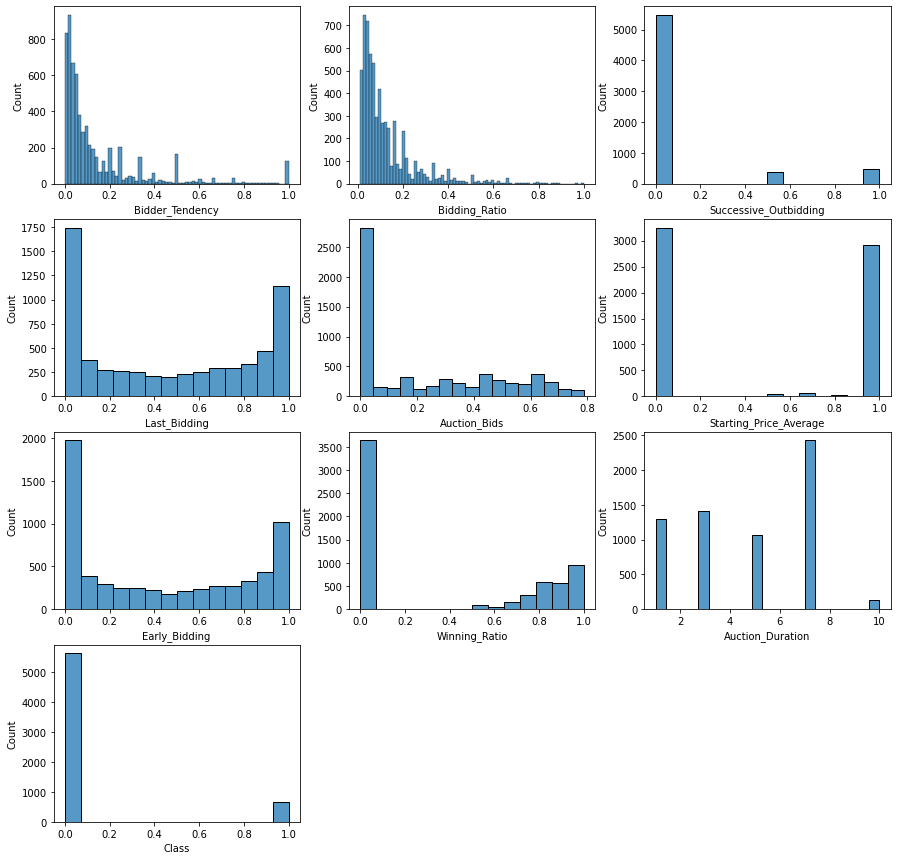

In [ ]:
plt.figure(figsize=(15,15))
i = 0

col_list = ['Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding', 'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding', 'Winning_Ratio', 'Auction_Duration', 'Class']
for col in col_list:
  i = i + 1
  plt.subplot(4,3,i)
  sns.histplot(data=data[col], legend=True)

plt.show()

Pair plot

<Figure size 1800x1440 with 0 Axes>

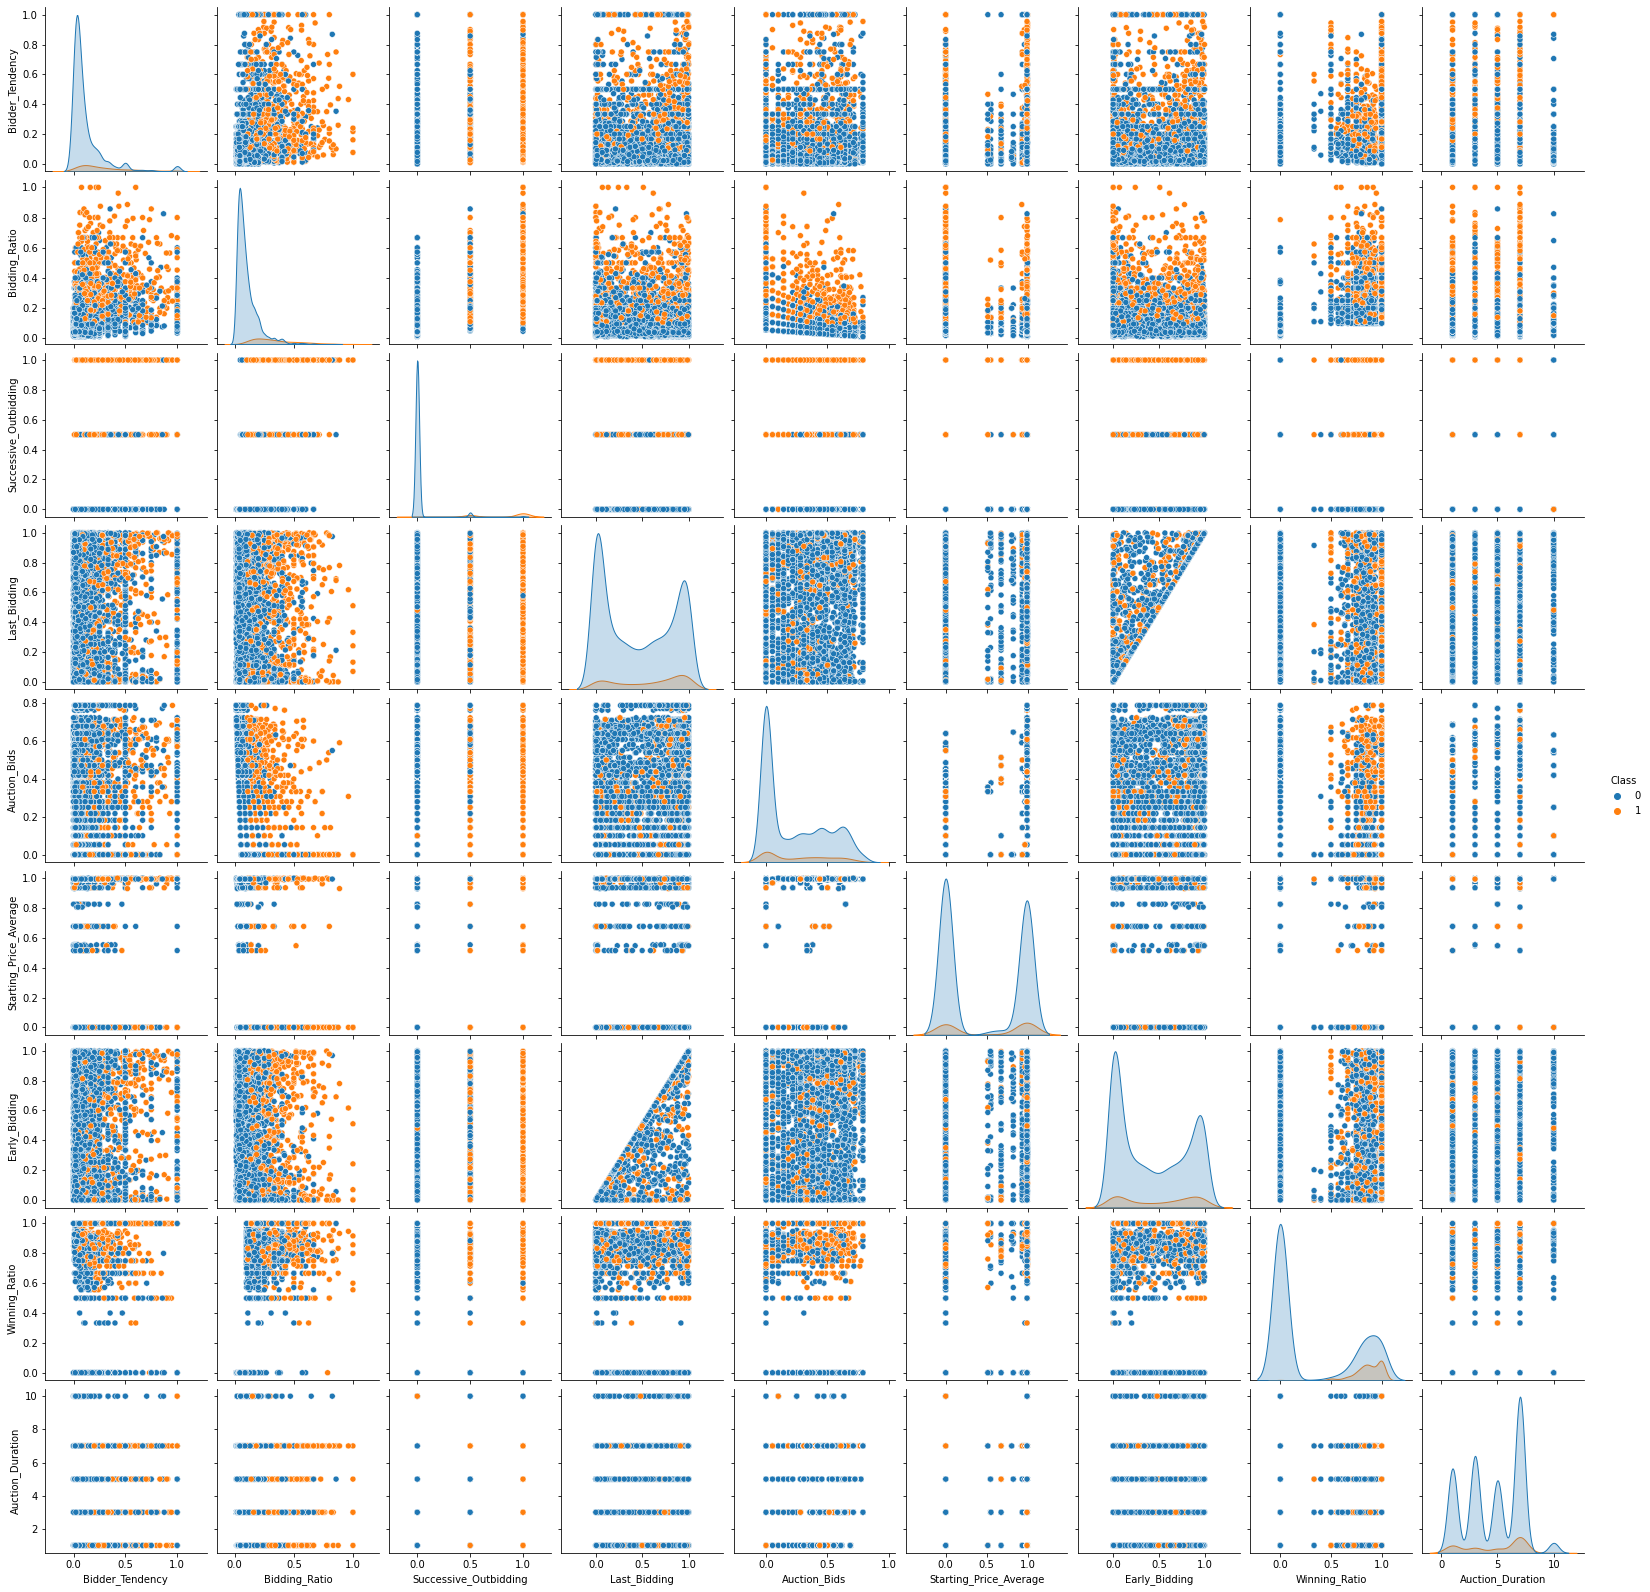

In [ ]:
plt.figure(figsize=(25,20))
sns.pairplot(data1, hue='Class')
plt.show()

**Observation:** No pair of two variables can separate the two class.

But Bidder_Tendency, Bidding_Ration and Successive_Outbidding show that the smaller values of the three features represent more normal bidders.

Another observation is that data might be able to be divided into groups by Auction_Duration without affecting the distribution.

Statistical analysis to confirm if there is a significant difference in each features among the Auction_Durations.

Since the features are all not normally distributed, I will use Kruskal-Wallis test.

Ho: there is no significant difference

Ha: there is significant difference

In [ ]:
from scipy import stats

data1_col_dur_list = ['Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding', 'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding', 'Winning_Ratio']

for col in data1_col_dur_list:
  print(col)
  dur_list = [1,3,5,7,10]

  for i in range(0,4):
    #print(dur_list[i])
    dur_list1 = dur_list[i+1:]
    #print(dur_list1)

    for j in dur_list1:
      print('Duration ',dur_list[i],'~ Duration ',j, ': pvalue=', stats.kruskal(data1[data1['Auction_Duration']==dur_list[i]][col], data1[data1['Auction_Duration']==j][col])[1])
      #print(stats.kruskal(data1[data1['Auction_Duration']==dur_list[i]][col], data1[data1['Auction_Duration']==j][col]))
    
  print('-------------------------------------------------------------------------------------------------------------')


Bidder_Tendency
Duration  1 ~ Duration  3 : pvalue= 0.6966023397831832
Duration  1 ~ Duration  5 : pvalue= 0.4793660843340304
Duration  1 ~ Duration  7 : pvalue= 0.9344002917017548
Duration  1 ~ Duration  10 : pvalue= 0.04517460218654448
Duration  3 ~ Duration  5 : pvalue= 0.7271581404175813
Duration  3 ~ Duration  7 : pvalue= 0.729742480022295
Duration  3 ~ Duration  10 : pvalue= 0.07443894016187297
Duration  5 ~ Duration  7 : pvalue= 0.48010036934088474
Duration  5 ~ Duration  10 : pvalue= 0.1183085861883225
Duration  7 ~ Duration  10 : pvalue= 0.05026859712280161
-------------------------------------------------------------------------------------------------------------
Bidding_Ratio
Duration  1 ~ Duration  3 : pvalue= 0.8239099593171679
Duration  1 ~ Duration  5 : pvalue= 0.1283495308898885
Duration  1 ~ Duration  7 : pvalue= 0.008958584749331476
Duration  1 ~ Duration  10 : pvalue= 0.00017401995356576726
Duration  3 ~ Duration  5 : pvalue= 0.07911828899622692
Duration  3 ~ Durati

In [ ]:
data1['Auction_Duration'].value_counts()

7     2427
3     1408
1     1289
5     1060
10     137
Name: Auction_Duration, dtype: int64

**Observation:** Many features are not significantly different between each auction duration pairs. However, Auction_Bids and Starting_Price_Average are mostly significantly different between auction duration pairs.
So, it should be safe to consider the shill bidder separately according to the action durations.

##2. Unsupervised algorithm evaluation
###2.1 Data preparation

In [ ]:
X1 = data1[data1['Auction_Duration']==1][['Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding', 'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding', 'Winning_Ratio']]
y1 = data1[data1['Auction_Duration']==1]['Class']
X3 = data1[data1['Auction_Duration']==3][['Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding', 'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding', 'Winning_Ratio']]
y3 = data1[data1['Auction_Duration']==3]['Class']
X5 = data1[data1['Auction_Duration']==5][['Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding', 'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding', 'Winning_Ratio']]
y5 = data1[data1['Auction_Duration']==5]['Class']
X7 = data1[data1['Auction_Duration']==7][['Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding', 'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding', 'Winning_Ratio']]
y7 = data1[data1['Auction_Duration']==7]['Class']
X10 = data1[data1['Auction_Duration']==10][['Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding', 'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding', 'Winning_Ratio']]
y10 = data1[data1['Auction_Duration']==10]['Class']

Dimension reduction for QC plot

In [ ]:
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

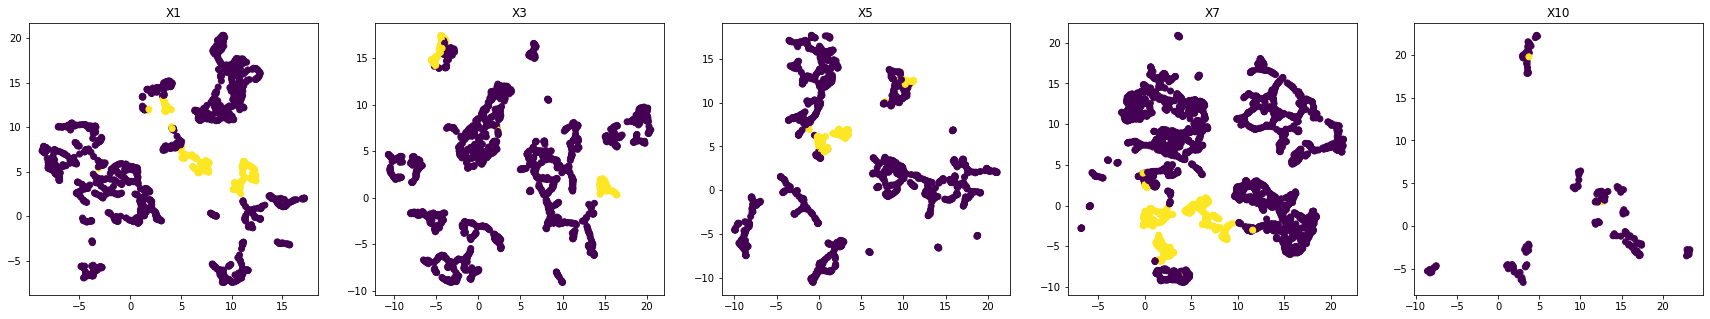

In [ ]:
plt.figure(figsize=(30,5))
 
X1_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation', random_state=42).fit_transform(X1)
plt.subplot(1,5,1)
plt.scatter(X1_umap[:,0], X1_umap[:,1], c=y1)
plt.title('X1')

X3_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation', random_state=42).fit_transform(X3)
plt.subplot(1,5,2)
plt.scatter(X3_umap[:,0], X3_umap[:,1], c=y3)
plt.title('X3')

X5_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation', random_state=42).fit_transform(X5)
plt.subplot(1,5,3)
plt.scatter(X5_umap[:,0], X5_umap[:,1], c=y5)
plt.title('X5')

X7_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation', random_state=42).fit_transform(X7)
plt.subplot(1,5,4)
plt.scatter(X7_umap[:,0], X7_umap[:,1], c=y7)
plt.title('X7')

X10_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation', random_state=42).fit_transform(X10)
plt.subplot(1,5,5)
plt.scatter(X10_umap[:,0], X10_umap[:,1], c=y10)
plt.title('X10')

plt.show()

[0.40872983 0.25755841]
[0.40568432 0.24013012]
[0.44401237 0.23478025]
[0.43191601 0.24643219]
[0.45369122 0.27598034]


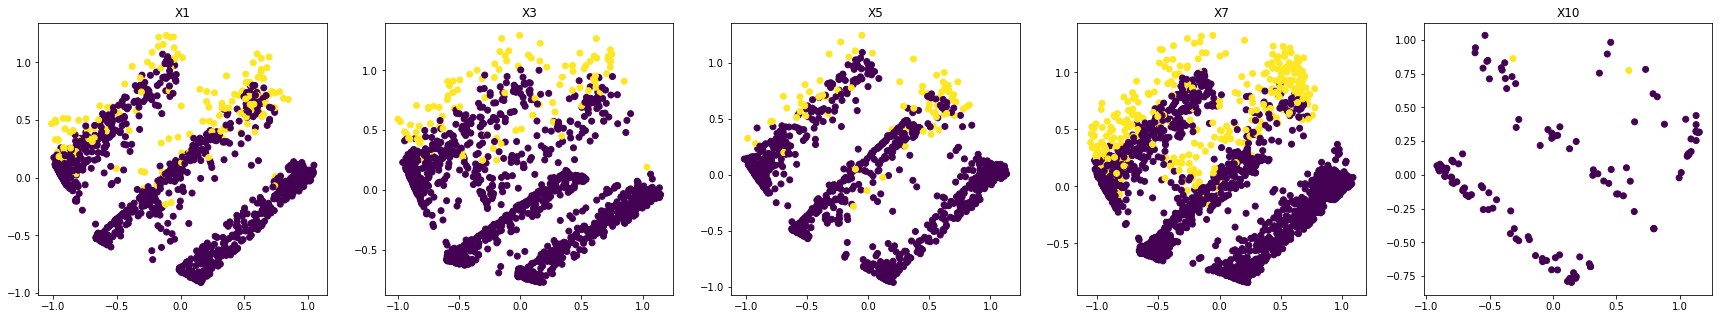

In [ ]:
plt.figure(figsize=(30,5))
 
X1_pca = PCA(n_components=2, random_state=42).fit_transform(X1)
print(PCA(n_components=2).fit(X1).explained_variance_ratio_)
plt.subplot(1,5,1)
plt.scatter(X1_pca[:,0], X1_pca[:,1], c=y1)
plt.title('X1')

X3_pca = PCA(n_components=2, random_state=42).fit_transform(X3)
print(PCA(n_components=2).fit(X3).explained_variance_ratio_)
plt.subplot(1,5,2)
plt.scatter(X3_pca[:,0], X3_pca[:,1], c=y3)
plt.title('X3')

X5_pca = PCA(n_components=2, random_state=42).fit_transform(X5)
print(PCA(n_components=2).fit(X5).explained_variance_ratio_)
plt.subplot(1,5,3)
plt.scatter(X5_pca[:,0], X5_pca[:,1], c=y5)
plt.title('X5')

X7_pca = PCA(n_components=2, random_state=42).fit_transform(X7)
print(PCA(n_components=2).fit(X7).explained_variance_ratio_)
plt.subplot(1,5,4)
plt.scatter(X7_pca[:,0], X7_pca[:,1], c=y7)
plt.title('X7')

X10_pca = PCA(n_components=2, random_state=42).fit_transform(X10)
print(PCA(n_components=2).fit(X10).explained_variance_ratio_)
plt.subplot(1,5,5)
plt.scatter(X10_pca[:,0], X10_pca[:,1], c=y10)
plt.title('X10')

plt.show()

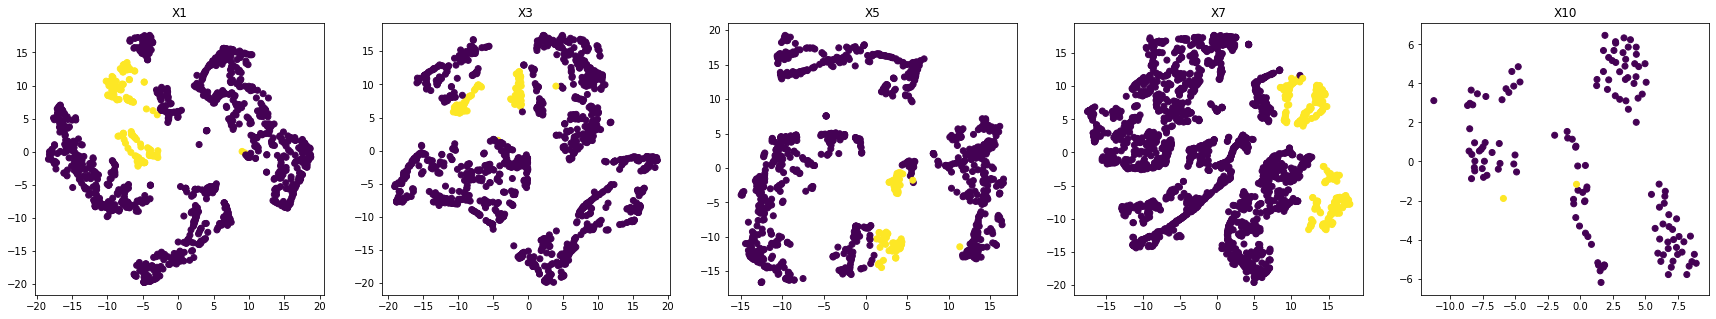

In [ ]:
plt.figure(figsize=(30,5))
 
X1_tsne = TSNE(n_components=2, perplexity=40, n_iter=300, random_state=42).fit_transform(X1)
plt.subplot(1,5,1)
plt.scatter(X1_tsne[:,0], X1_tsne[:,1], c=y1)
plt.title('X1')

X3_tsne = TSNE(n_components=2, perplexity=40, n_iter=300, random_state=42).fit_transform(X3)
plt.subplot(1,5,2)
plt.scatter(X3_tsne[:,0], X3_tsne[:,1], c=y3)
plt.title('X3')

X5_tsne = TSNE(n_components=2, perplexity=40, n_iter=300, random_state=42).fit_transform(X5)
plt.subplot(1,5,3)
plt.scatter(X5_tsne[:,0], X5_tsne[:,1], c=y5)
plt.title('X5')

X7_tsne = TSNE(n_components=2, perplexity=40, n_iter=300, random_state=42).fit_transform(X7)
plt.subplot(1,5,4)
plt.scatter(X7_tsne[:,0], X7_tsne[:,1], c=y7)
plt.title('X7')

X10_tsne = TSNE(n_components=2, perplexity=40, n_iter=300, random_state=42).fit_transform(X10)
plt.subplot(1,5,5)
plt.scatter(X10_tsne[:,0], X10_tsne[:,1], c=y10)
plt.title('X10')

plt.show()

**Observation:** 
* The first two components of PCA presents 65~73% variables, and do not separate the two classes as well as umap and tsne methods. 
* tsne shows the most split clusters to separate the classes. 
* And one more thing is interesting to point out that the data looks not to contain only two clusters, although the normal bidders and shill bidders are two classes. So I think there should be more than two clusters can be labeled as normal bidders and the others can be labeled as shill bidders.

###2.2 Algorithms evaluation

In [ ]:
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import scipy
from sklearn import metrics

Max silhouette coeficient for X1 is 0.4719669924586248 for 10 cluster
Max silhouette coeficient for X3 is 0.4572223569773677 for 10 cluster
Max silhouette coeficient for X5 is 0.5046749101132672 for 10 cluster
Max silhouette coeficient for X7 is 0.4677716313148853 for 10 cluster
Max silhouette coeficient for X10 is 0.5292520401728247 for 8 cluster


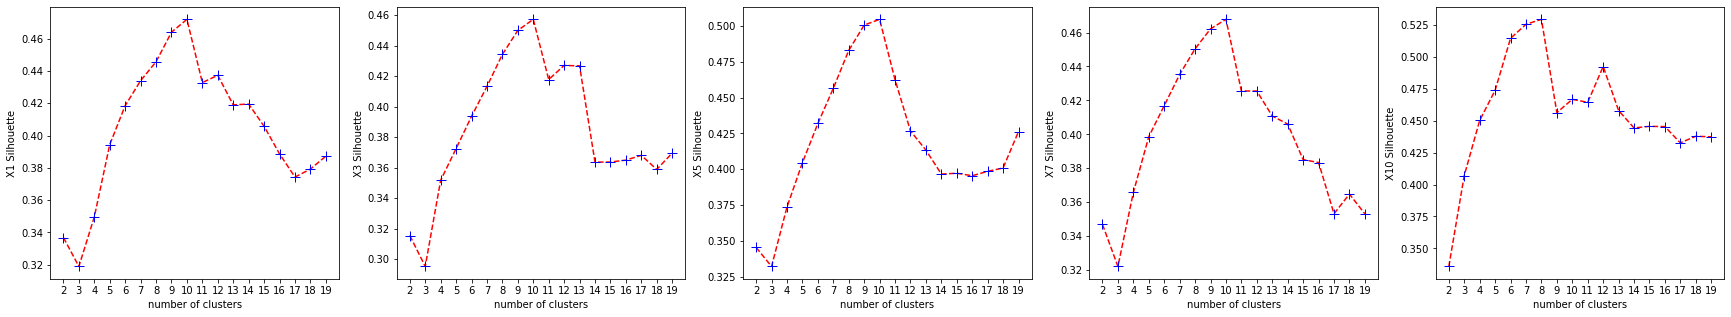

In [ ]:
### KMeans parameter scan
plt.figure(figsize=(30,5))

X_list = {'X1':X1, 'X3':X3, 'X5':X5, 'X7':X7, 'X10':X10}
i=0

for x_str, x in X_list.items():
  silhouette_list = []
  i=i+1
  for k in range(2,20):
    kmeans_fit = KMeans(n_clusters=k, max_iter=300, random_state=42).fit(x)
    y_pred = kmeans_fit.predict(x)
    silhouette_list.append(metrics.silhouette_score(x, y_pred, metric='euclidean'))
  plt.subplot(1,5,i)
  plt.plot(range(2,20),silhouette_list, marker = '+',color = 'red' , ls = '--', markeredgecolor = 'blue', markersize = '10')
  plt.ylabel(x_str+' Silhouette')
  plt.xlabel('number of clusters')
  plt.xticks(np.arange(2,20,1))
  max_s = max(silhouette_list)
  max_k = silhouette_list.index(max_s)+2
  print('Max silhouette coeficient for {} is {} for {} cluster'.format(x_str, max_s, max_k))

plt.show()

Method: ward: X1: n_neighbors: 10, Max Silhouette coefficient: 0.44999615523186515
Method: ward: X3: n_neighbors: 11, Max Silhouette coefficient: 0.4407952486452096
Method: ward: X5: n_neighbors: 11, Max Silhouette coefficient: 0.4816596725564041
Method: ward: X7: n_neighbors: 9, Max Silhouette coefficient: 0.38785472788195535
Method: ward: X10: n_neighbors: 10, Max Silhouette coefficient: 0.5365236390855176
Method: complete: X1: n_neighbors: 12, Max Silhouette coefficient: 0.3543817347414326
Method: complete: X3: n_neighbors: 2, Max Silhouette coefficient: 0.3010061763956822
Method: complete: X5: n_neighbors: 11, Max Silhouette coefficient: 0.4034030940534714
Method: complete: X7: n_neighbors: 16, Max Silhouette coefficient: 0.32773732934452754
Method: complete: X10: n_neighbors: 10, Max Silhouette coefficient: 0.527280283182995
Method: average: X1: n_neighbors: 18, Max Silhouette coefficient: 0.33630235268084985
Method: average: X3: n_neighbors: 16, Max Silhouette coefficient: 0.2898

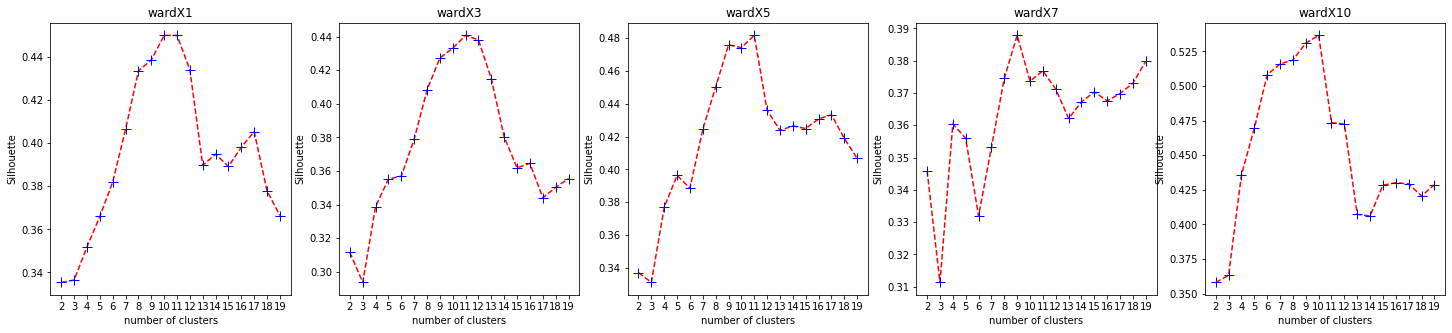

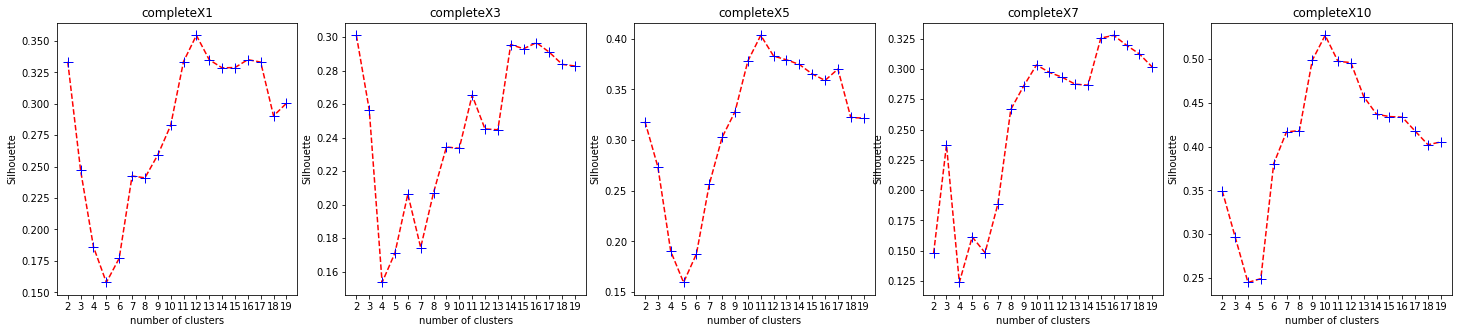

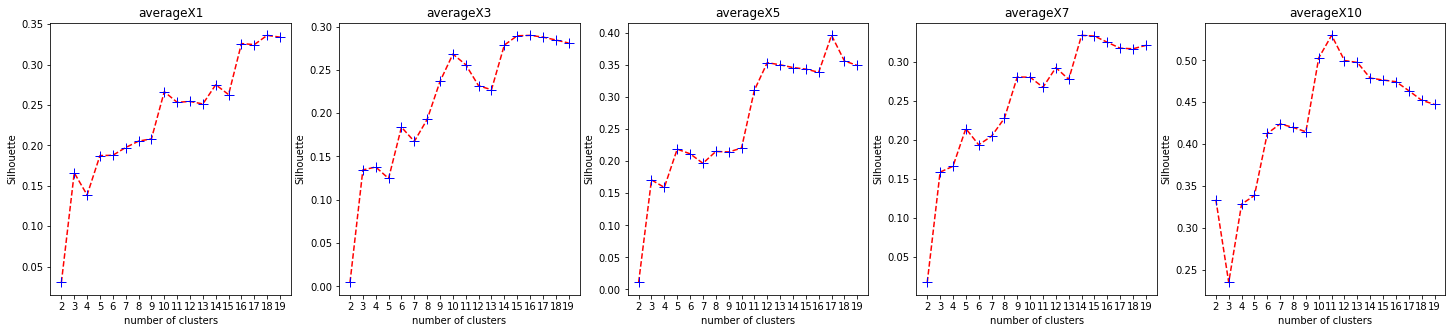

In [ ]:
### Agglomerative clustering parameter scan

method_list = ['ward', 'complete', 'average']

for method in method_list:
  sim = 'cosine'
  if(method=='ward'):
    sim = 'euclidean'
  i = 0
  plt.figure(figsize=(25,5))

  for x_str, x in X_list.items():
    silhouette_list = []

    for k in range(2,20):
      pred = AgglomerativeClustering(n_clusters=k, affinity=sim, linkage=method).fit_predict(x)
      silhouette_list.append(metrics.silhouette_score(x, pred, metric='euclidean'))
    max_s = max(silhouette_list)
    max_k = silhouette_list.index(max_s)+2
    print('Method: {}: {}: n_neighbors: {}, Max Silhouette coefficient: {}'.format(method, x_str, max_k, max_s))

    i = i + 1
    plt.subplot(1,5,i)
    plt.plot(range(2,20), silhouette_list, marker = '+',color = 'red' , ls = '--', markeredgecolor = 'blue', markersize = '10')
    plt.title(method+x_str)
    plt.ylabel('Silhouette')
    plt.xlabel('number of clusters')
    plt.xticks(np.arange(2,20,1))

plt.show()

In [ ]:
### DBSCAN

eps_list = [0.2, 0.5, 0.7]
for eps_n in eps_list:
  silhouette_list = []

  for sp_n in range(1, 20):
    pred = DBSCAN(eps=eps_n, min_samples=sp_n).fit_predict(X3)
    silhouette_list.append(metrics.silhouette_score(X3, pred, metric='euclidean'))
  max_s = max(silhouette_list)
    #max_k = silhouette_list.index(max_s)+2
  print('eps: {},  min_sample: {},  {}, Max Silhouette coefficient: {}'.format(eps_n, sp_n, 'X3', max_s))

  for sp_n in range(1, 20):
    pred = DBSCAN(eps=eps_n, min_samples=sp_n).fit_predict(X5)
    silhouette_list.append(metrics.silhouette_score(X5, pred, metric='euclidean'))
  max_s = max(silhouette_list)
    #max_k = silhouette_list.index(max_s)+2
  print('eps: {},  min_sample: {},  {}, Max Silhouette coefficient: {}'.format(eps_n, sp_n, 'X5', max_s))

  for sp_n in range(1, 20):
    pred = DBSCAN(eps=eps_n, min_samples=sp_n).fit_predict(X7)
    silhouette_list.append(metrics.silhouette_score(X7, pred, metric='euclidean'))
  max_s = max(silhouette_list)
    #max_k = silhouette_list.index(max_s)+2
  print('eps: {},  min_sample: {},  {}, Max Silhouette coefficient: {}'.format(eps_n, sp_n, 'X7', max_s))

eps: 0.2,  min_sample: 19,  X3, Max Silhouette coefficient: 0.1888354663410392
eps: 0.2,  min_sample: 19,  X5, Max Silhouette coefficient: 0.27091413495528915
eps: 0.2,  min_sample: 19,  X7, Max Silhouette coefficient: 0.2771798287747163
eps: 0.5,  min_sample: 19,  X3, Max Silhouette coefficient: 0.2073361904325334
eps: 0.5,  min_sample: 19,  X5, Max Silhouette coefficient: 0.2944246244617833
eps: 0.5,  min_sample: 19,  X7, Max Silhouette coefficient: 0.2944246244617833
eps: 0.7,  min_sample: 19,  X3, Max Silhouette coefficient: 0.25810890649881946
eps: 0.7,  min_sample: 19,  X5, Max Silhouette coefficient: 0.25810890649881946
eps: 0.7,  min_sample: 19,  X7, Max Silhouette coefficient: 0.25810890649881946


DBSCAN has overall low Silhouette coeffcients, and results in 1 cluster for X1 and X10. So I decide to exclude the DBSCAN for this project.

Method: full: X1: n_neighbors: 2, Max Silhouette coefficient: 0.3350249603951887
Method: full: X3: n_neighbors: 6, Max Silhouette coefficient: 0.28234375309251447
Method: full: X5: n_neighbors: 5, Max Silhouette coefficient: 0.29249748984425056
Method: full: X7: n_neighbors: 2, Max Silhouette coefficient: 0.345826584730947
Method: full: X10: n_neighbors: 12, Max Silhouette coefficient: 0.3804393878266459
Method: tied: X1: n_neighbors: 10, Max Silhouette coefficient: 0.45882116619882074
Method: tied: X3: n_neighbors: 13, Max Silhouette coefficient: 0.42641808280574156
Method: tied: X5: n_neighbors: 9, Max Silhouette coefficient: 0.4799595882245385
Method: tied: X7: n_neighbors: 11, Max Silhouette coefficient: 0.44271866657159525
Method: tied: X10: n_neighbors: 7, Max Silhouette coefficient: 0.5247264097540775
Method: diag: X1: n_neighbors: 2, Max Silhouette coefficient: 0.3350249603951887
Method: diag: X3: n_neighbors: 9, Max Silhouette coefficient: 0.3945654032164171
Method: diag: X5: 

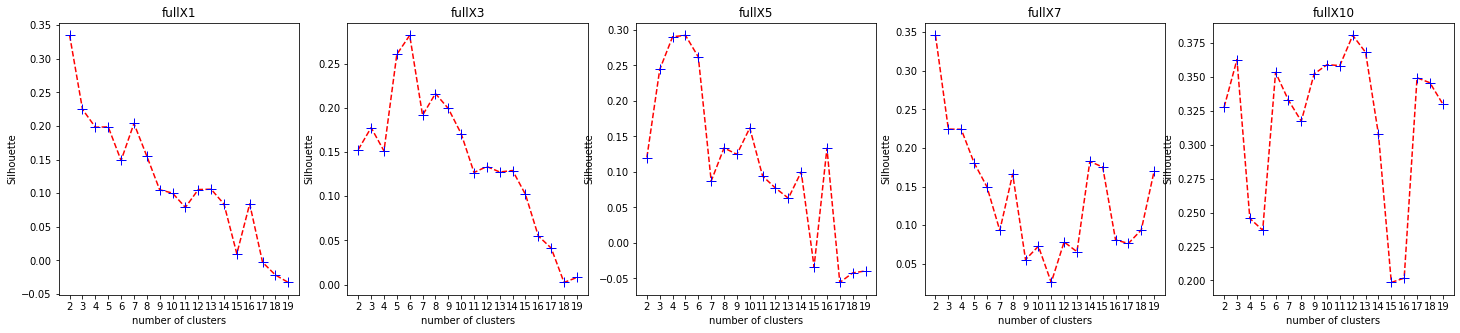

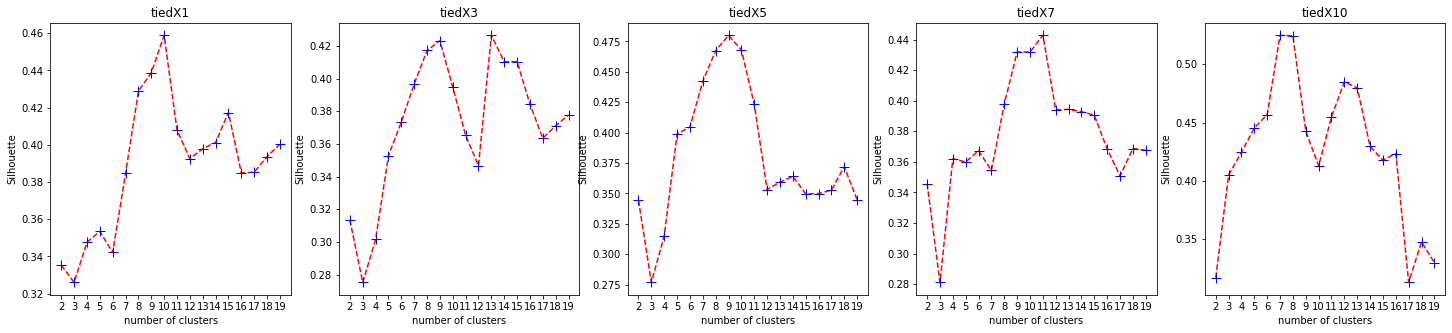

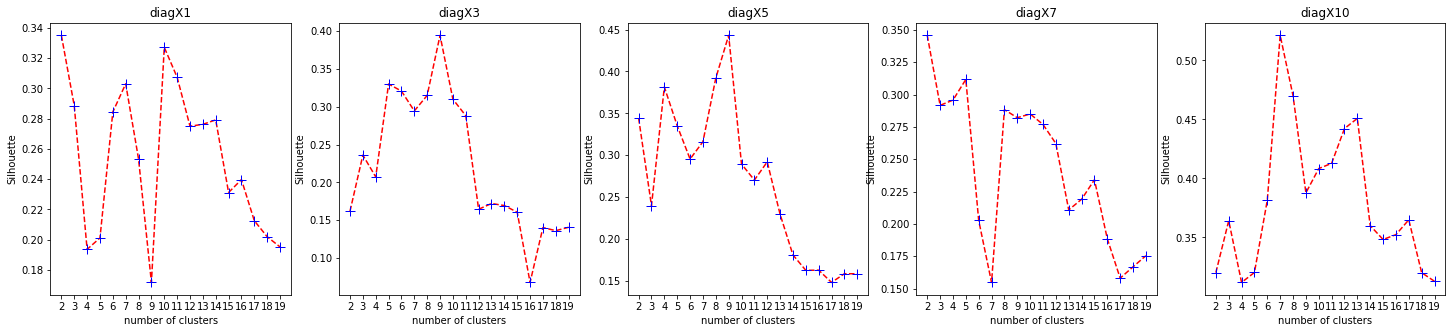

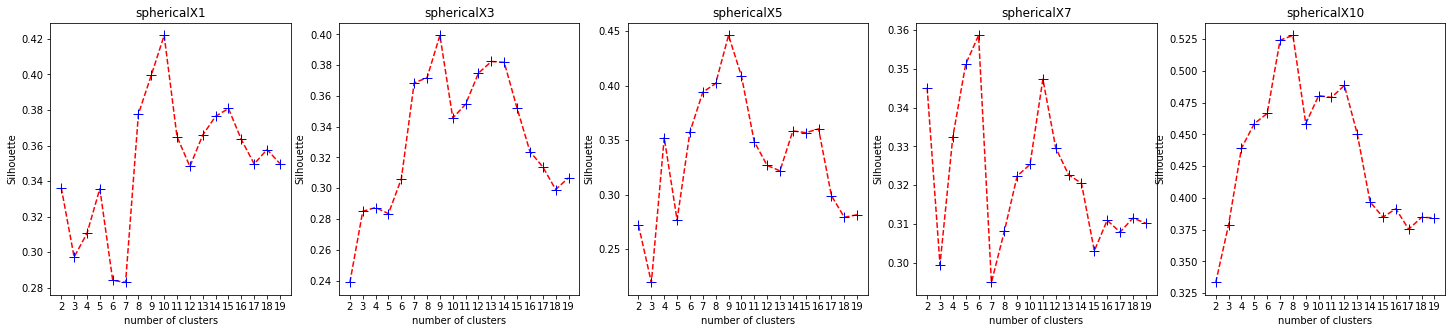

In [ ]:
###GMM parameter scan

covariace_list = ['full', 'tied', 'diag', 'spherical']

for cov in covariace_list:
  i = 0
  plt.figure(figsize=(25,5))

  for x_str, x in X_list.items():
    silhouette_list = []

    for k in range(2,20):
      pred = GaussianMixture(n_components=k, covariance_type=cov, random_state=42).fit_predict(x)
      silhouette_list.append(metrics.silhouette_score(x, pred, metric='euclidean'))
    max_s = max(silhouette_list)
    max_k = silhouette_list.index(max_s)+2
    print('Method: {}: {}: n_neighbors: {}, Max Silhouette coefficient: {}'.format(cov, x_str, max_k, max_s))

    i = i + 1
    plt.subplot(1,5,i)
    plt.plot(range(2,20), silhouette_list, marker = '+',color = 'red' , ls = '--', markeredgecolor = 'blue', markersize = '10')
    plt.title(cov+x_str)
    plt.ylabel('Silhouette')
    plt.xlabel('number of clusters')
    plt.xticks(np.arange(2,20,1))

plt.show()

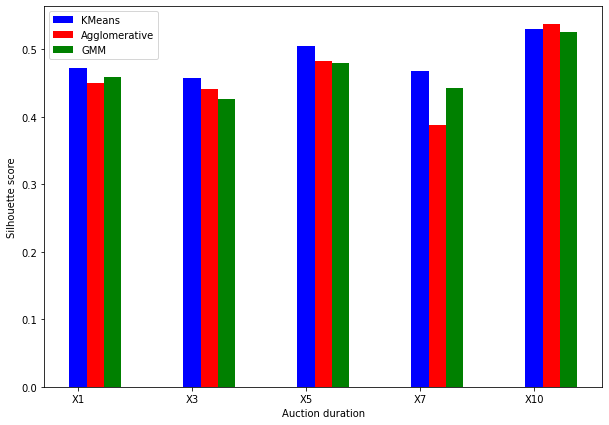

In [ ]:
### Silhouette score examination

sil_df = pd.DataFrame(index=['X1', 'X3', 'X5', 'X7', 'X10'], columns=['KMeans', 'Agglomerative', 'GMM'])
sil_df['KMeans'] = [0.4719669924586248,0.4572223569773677,0.5046749101132672,0.4677716313148853,0.5292520401728247]
sil_df['Agglomerative'] = [0.44999615523186515,0.4407952486452096,0.4816596725564041,0.38785472788195535,0.5365236390855176]
sil_df['GMM'] = [0.45882116619882074,0.42641808280574156,0.4799595882245385,0.44271866657159525,0.5247264097540775]

plt.figure(figsize=(10,7))
X_ind = np.arange(sil_df.shape[0])
index_list = ['X1', 'X3', 'X5', 'X7', 'X10']
plt.bar(X_ind, sil_df['KMeans'], color='b', width=0.15)
plt.bar(X_ind+0.15, sil_df['Agglomerative'], color='r', width=0.15)
plt.bar(X_ind+0.3, sil_df['GMM'], color='g', width=0.15)
plt.xticks(X_ind, index_list)
plt.xlabel('Auction duration')
plt.ylabel('Silhouette score')
plt.legend(labels=['KMeans', 'Agglomerative', 'GMM'])
plt.show()

**Observation:** KMeans overall shows the best Silhouette scores, and I will use KMeans for clustering.

##3. Clustering using KMeans

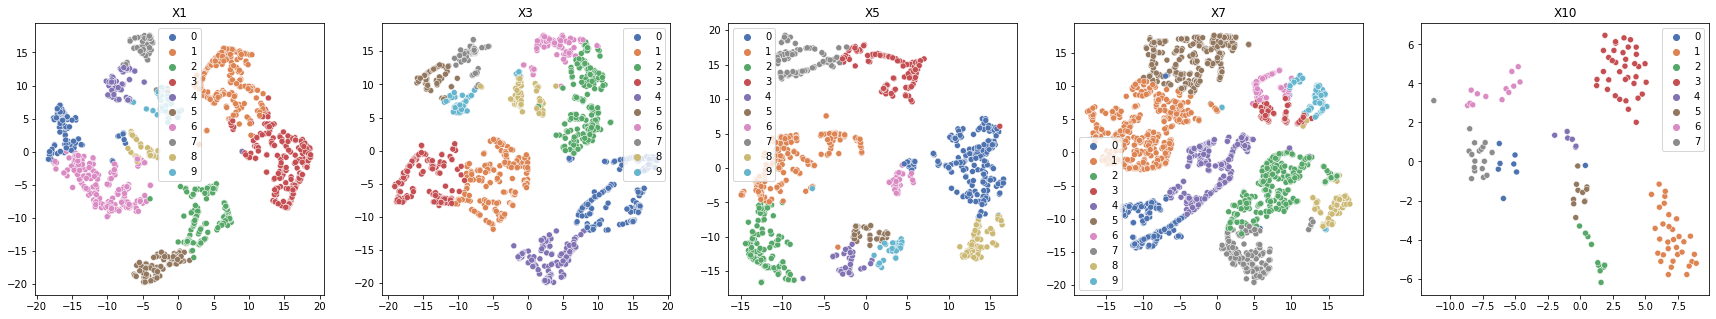

In [ ]:
###KMeans Prediction

plt.figure(figsize=(30,5))

plt.subplot(1,5,1)
y1_kmeans = KMeans(n_clusters=10, random_state=42).fit_predict(X1)
sns.scatterplot(x=X1_tsne[:,0], y=X1_tsne[:,1], hue=y1_kmeans, palette="deep")
plt.title('X1')

plt.subplot(1,5,2)
y3_kmeans = KMeans(n_clusters=10, random_state=42).fit_predict(X3)
sns.scatterplot(x=X3_tsne[:,0], y=X3_tsne[:,1], hue=y3_kmeans, palette="deep")
plt.title('X3')

plt.subplot(1,5,3)
y5_kmeans = KMeans(n_clusters=10, random_state=42).fit_predict(X5)
sns.scatterplot(x=X5_tsne[:,0], y=X5_tsne[:,1], hue=y5_kmeans, palette="deep")
plt.title('X5')

plt.subplot(1,5,4)
y7_kmeans = KMeans(n_clusters=10, random_state=42).fit_predict(X7)
sns.scatterplot(x=X7_tsne[:,0], y=X7_tsne[:,1], hue=y7_kmeans, palette="deep")
plt.title('X7')

plt.subplot(1,5,5)
y10_kmeans = KMeans(n_clusters=8, random_state=42).fit_predict(X10)
sns.scatterplot(x=X10_tsne[:,0], y=X10_tsne[:,1], hue=y10_kmeans, palette="deep")
plt.title('X10')

plt.show()

Observation: As mentioned in the data exploration section, the clustering results in multiple clusters more than two. So the labeling will be cluster by cluster for each group of auction duration.

##4. Labeling

**Labeling algorithm -- Voting method:**
1. for each auction duration group, calculate the mean value of all feature -- group mean
2. for each cluster, calculate the mean value for each feature -- feature mean
* if (feature mean > group mean): vote 1
* else: vote 0 
3. for each cluster, sum the votes (total 8 features)
* if (vote > 4): Shill bidding
* if (vote < 4): Normal bidding
* else: Suspicious bidding

In [ ]:
X1a = X1.copy()
X3a = X3.copy()
X5a = X5.copy()
X7a = X7.copy()
X10a = X10.copy()
X1a['class_kmeans'] = y1_kmeans
X3a['class_kmeans'] = y3_kmeans
X5a['class_kmeans'] = y5_kmeans
X7a['class_kmeans'] = y7_kmeans
X10a['class_kmeans'] = y10_kmeans

Labeling

In [ ]:
### X1
Xmean_list = []
Xstd_list = []

for col_num in range(0,8):
  Xmean_list.append(X1.iloc[:,col_num].mean())
  Xstd_list.append(X1.iloc[:,col_num].std())

X1_mean = sum(Xmean_list)/len(Xmean_list)
X1_std = sum(Xstd_list)/len(Xstd_list)
print(X1_mean, X1_std)

0.29497526588023626 0.3143228911557808


'\nfor i in range(0,10):\n  x1_mod = KMeans(n_clusters=10, random_state=42).fit(X1)\n  print(x1_mod.cluster_centers_[i])\n  print("%.4f" % x1_mod.cluster_centers_[i].mean())\n'

In [ ]:
for cluster_num in range(0,10):
  cluster_total = 0

  for col_num in range(0,8):
    cluster_mean = X1a[X1a['class_kmeans']==cluster_num].iloc[:,col_num].mean()

    if cluster_mean > X1_mean:
      cluster_total = cluster_total + 1
    else:
      cluster_total = cluster_total

  print(cluster_num, cluster_total)

0 3
1 2
2 0
3 4
4 7
5 2
6 1
7 4
8 5
9 2


Class     0    1
row_0           
0      1135   34
1         0  120


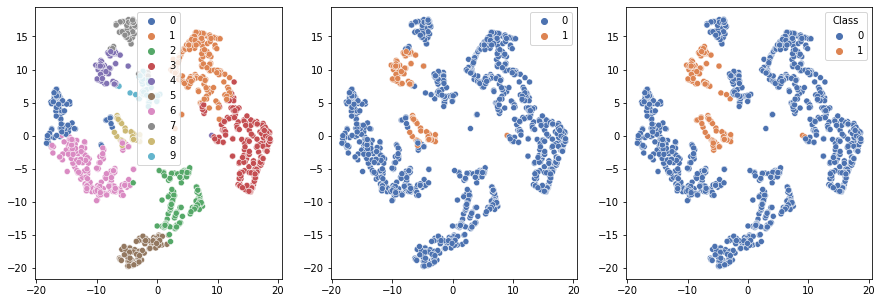

In [ ]:
y1_upt = np.array([1 if x==4 else 1 if x==8 else 0 for x in y1_kmeans])
print(pd.crosstab(y1_upt, y1))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.scatterplot(x=X1_tsne[:,0], y=X1_tsne[:,1], hue=y1_kmeans, palette="deep")
plt.subplot(1,3,2)
sns.scatterplot(x=X1_tsne[:,0], y=X1_tsne[:,1], hue=y1_upt, palette="deep")
plt.subplot(1,3,3)
sns.scatterplot(x=X1_tsne[:,0], y=X1_tsne[:,1], hue=y1, palette="deep")
plt.show()

In [ ]:
### X3

Xmean_list = []
Xstd_list = []

for col_num in range(0,8):
  Xmean_list.append(X3.iloc[:,col_num].mean())
  Xstd_list.append(X3.iloc[:,col_num].std())

X3_mean = sum(Xmean_list)/len(Xmean_list)
X3_std = sum(Xstd_list)/len(Xstd_list)
print(X3_mean, X3_std)

0.28039343887093415 0.3145417539285518


In [ ]:
for cluster_num in range(0,10):
  cluster_total = 0

  for col_num in range(0,8):
    cluster_mean = X3a[X3a['class_kmeans']==cluster_num].iloc[:,col_num].mean()
    Xmean = X3.iloc[:,col_num].mean()
    Xstd = X3.iloc[:,col_num].std()

    if cluster_mean > X3_mean:
      cluster_total = cluster_total + 1
    else:
      cluster_total = cluster_total

  print(cluster_num, cluster_total)

0 0
1 4
2 1
3 1
4 2
5 4
6 3
7 2
8 4
9 8


Class     0   1
row_0          
0      1291  59
1        12  46


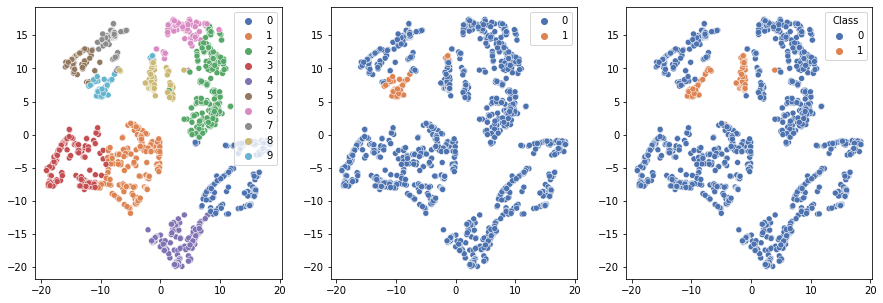

In [ ]:
y3_upt = np.array([1 if x == 9 else 0 for x in y3_kmeans])
print(pd.crosstab(y3_upt, y3))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.scatterplot(x=X3_tsne[:,0], y=X3_tsne[:,1], hue=y3_kmeans, palette="deep")
plt.subplot(1,3,2)
sns.scatterplot(x=X3_tsne[:,0], y=X3_tsne[:,1], hue=y3_upt, palette="deep")
plt.subplot(1,3,3)
sns.scatterplot(x=X3_tsne[:,0], y=X3_tsne[:,1], hue=y3, palette="deep")
plt.show()

In [ ]:
### X5
Xmean_list = []
Xstd_list = []

for col_num in range(0,8):
  Xmean_list.append(X5.iloc[:,col_num].mean())
  Xstd_list.append(X5.iloc[:,col_num].std())

X5_mean = sum(Xmean_list)/len(Xmean_list)
X5_std = sum(Xstd_list)/len(Xstd_list)
print(X5_mean, X5_std)

0.2901922211889979 0.31952181752459563


In [ ]:
for cluster_num in range(0,10):
  cluster_total = 0

  for col_num in range(0,8):
    cluster_mean = X5a[X5a['class_kmeans']==cluster_num].iloc[:,col_num].mean()

    if cluster_mean > X5_mean:
      cluster_total = cluster_total + 1
    else:
      cluster_total = cluster_total

  print(cluster_num, cluster_total)

0 1
1 4
2 2
3 0
4 2
5 4
6 5
7 2
8 3
9 7


Class    0   1
row_0         
0      969  17
1        6  68


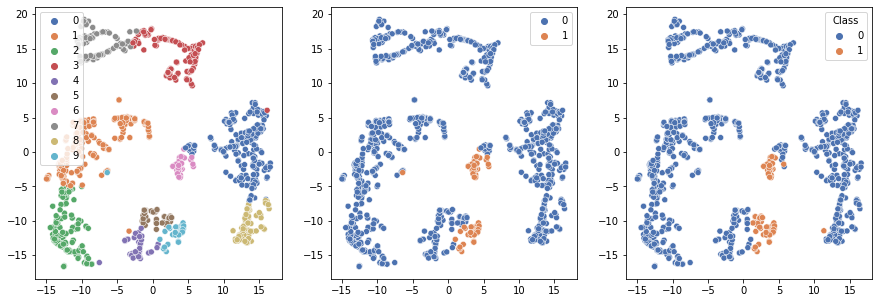

In [ ]:
y5_upt = np.array([1 if x==6 else 1 if x==9 else 0 for x in y5_kmeans])
print(pd.crosstab(y5_upt, y5))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.scatterplot(x=X5_tsne[:,0], y=X5_tsne[:,1], hue=y5_kmeans, palette="deep")
plt.subplot(1,3,2)
sns.scatterplot(x=X5_tsne[:,0], y=X5_tsne[:,1], hue=y5_upt, palette="deep")
plt.subplot(1,3,3)
sns.scatterplot(x=X5_tsne[:,0], y=X5_tsne[:,1], hue=y5, palette="deep")
plt.show()

In [ ]:
### X7
Xmean_list = []
Xstd_list = []

for col_num in range(0,8):
  Xmean_list.append(X7.iloc[:,col_num].mean())
  Xstd_list.append(X7.iloc[:,col_num].std())

X7_mean = sum(Xmean_list)/len(Xmean_list)
X7_std = sum(Xstd_list)/len(Xstd_list)
print(X7_mean, X7_std)

0.29759729669072393 0.3226681521744645


In [ ]:
for cluster_num in range(0,10):
  cluster_total = 0

  for col_num in range(0,8):
    cluster_mean = X7a[X7a['class_kmeans']==cluster_num].iloc[:,col_num].mean()

    if cluster_mean > X7_mean:
      cluster_total = cluster_total + 1
    else:
      cluster_total = cluster_total

  print(cluster_num, cluster_total)

0 2
1 4
2 1
3 3
4 0
5 2
6 4
7 3
8 4
9 7


Class     0    1
row_0           
0      2089  216
1         9  113


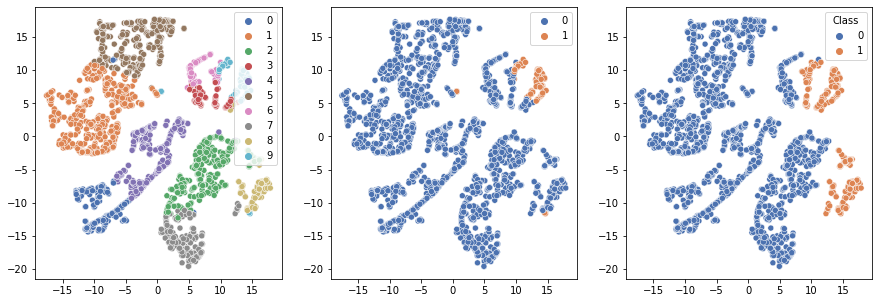

In [ ]:
y7_upt = np.array([1 if x == 9 else 0 for x in y7_kmeans])
print(pd.crosstab(y7_upt, y7))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.scatterplot(x=X7_tsne[:,0], y=X7_tsne[:,1], hue=y7_kmeans, palette="deep")
plt.subplot(1,3,2)
sns.scatterplot(x=X7_tsne[:,0], y=X7_tsne[:,1], hue=y7_upt, palette="deep")
plt.subplot(1,3,3)
sns.scatterplot(x=X7_tsne[:,0], y=X7_tsne[:,1], hue=y7, palette="deep")
plt.show()

In [ ]:
### X10
Xmean_list = []
Xstd_list = []

for col_num in range(0,8):
  Xmean_list.append(X10.iloc[:,col_num].mean())
  Xstd_list.append(X10.iloc[:,col_num].std())

X10_mean = sum(Xmean_list)/len(Xmean_list)
X10_std = sum(Xstd_list)/len(Xstd_list)
print(X10_mean, X10_std)

0.3209112630176094 0.3080047506086104


In [ ]:
for cluster_num in range(0,10):
  cluster_total = 0

  for col_num in range(0,8):
    cluster_mean = X10a[X10a['class_kmeans']==cluster_num].iloc[:,col_num].mean()

    if cluster_mean > X10_mean:
      cluster_total = cluster_total + 1
    else:
      cluster_total = cluster_total

  print(cluster_num, cluster_total)

0 3
1 2
2 2
3 4
4 8
5 4
6 2
7 1
8 0
9 0


Class    0  1
row_0        
0      129  2
1        6  0


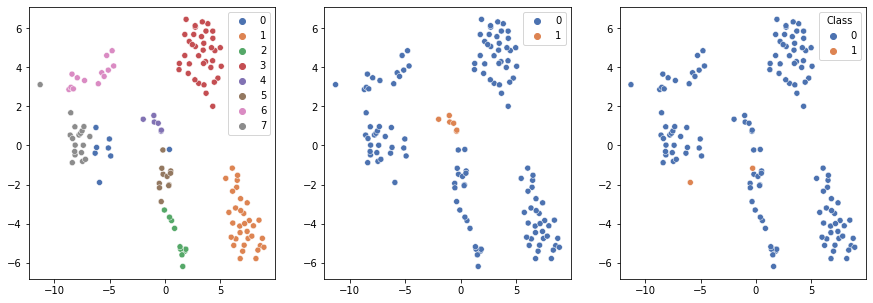

In [ ]:
y10_upt = np.array([1 if x == 4 else 0 for x in y10_kmeans])
print(pd.crosstab(y10_upt, y10))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.scatterplot(x=X10_tsne[:,0], y=X10_tsne[:,1], hue=y10_kmeans, palette="deep")
plt.subplot(1,3,2)
sns.scatterplot(x=X10_tsne[:,0], y=X10_tsne[:,1], hue=y10_upt, palette="deep")
plt.subplot(1,3,3)
sns.scatterplot(x=X10_tsne[:,0], y=X10_tsne[:,1], hue=y10, palette="deep")
plt.show()

In [ ]:
X1['class_set'] = y1_upt
X3['class_set'] = y3_upt
X5['class_set'] = y5_upt
X7['class_set'] = y7_upt
X10['class_set'] = y10_upt

In [ ]:
frames = [X1,X3,X5,X7,X10]
data2 = pd.concat(frames)
data2.sort_index(inplace=True)
data2['Class'] = data1['Class']
data2.head()

Bidder_Tendency  Bidding_Ratio  ...  class_set  Class
0         0.200000       0.400000  ...          0      0
1         0.024390       0.200000  ...          0      0
2         0.142857       0.200000  ...          0      0
3         0.100000       0.200000  ...          0      0
4         0.051282       0.222222  ...          0      0

[5 rows x 10 columns]

In [ ]:
print('Ground truth')
print(data2['Class'].value_counts())
print('Clustering and labeling')
print(data2['class_set'].value_counts())

Ground truth
0    5646
1     675
Name: Class, dtype: int64
Clustering and labeling
0    5941
1     380
Name: class_set, dtype: int64


##5. Results and discussion
As we can see, some groups like X1 and X5 show reasonable prediction close to ground truth, while some not, like 3, and X7. However, as mentioned in the introduction section, behaviors of some fraud bidders are very similar with those of normal bidders. Let's look at below examples:

In [ ]:
duration7_index_list = [13,6231, 6285, 6289]
data1[data1.index.isin(duration7_index_list)]

Bidder_Tendency  Bidding_Ratio  ...  Auction_Duration  Class
13           0.041322       0.208333  ...                 7      1
6231         0.166667       0.076923  ...                 7      0
6285         0.281690       0.740741  ...                 7      1
6289         0.592593       0.615385  ...                 7      1

[4 rows x 10 columns]

When we examine the ground truth, we can see 6231 and 6285 can be easily identified as normal and shill, while 13 looks closr to 6231 and 6289 looks closer to 6285, so the accuracy of ground truth is worth further examination. On the other hand, there should be lots of case confusing the clustering algorithms.

How about we have three groups: normal, suspicious, shill?

Those suspicious clusters (total number of feature mean > total mean is 4) can be identified for each duration group as below.

X1: 3, 7; X3: 1, 5, 8; X5: 1, 5; X7: 1, 6, 8; X10: 3, 5.

In [ ]:
y1_upt = np.array([1 if x==4 else 1 if x==8 else 2 if x==3 else 2 if x==7 else 0 for x in y1_kmeans])
y5_upt = np.array([1 if x==6 else 1 if x==9 else 2 if x==1 else 2 if x==5 else 2 if x==8 else 0 for x in y5_kmeans])
y3_upt = np.array([1 if x == 9 else 2 if x==1 else 2 if x==5 else 0 for x in y3_kmeans])
y7_upt = np.array([1 if x == 9 else 2 if x==1 else 2 if x==6 else 2 if x==8 else 0 for x in y7_kmeans])
y10_upt = np.array([1 if x == 4 else 2 if x==3 else 2 if x==5 else 0 for x in y10_kmeans])

In [ ]:
X1['class_3set'] = y1_upt
X3['class_3set'] = y3_upt
X5['class_3set'] = y5_upt
X7['class_3set'] = y7_upt
X10['class_3set'] = y10_upt

frames = [X1,X3,X5,X7,X10]
data2 = pd.concat(frames)
data2.sort_index(inplace=True)
data2['class_3set'].value_counts()

0    4188
2    1753
1     380
Name: class_3set, dtype: int64

In [ ]:
print(np.unique(y1_upt, return_counts=True))
print(np.unique(y3_upt, return_counts=True))
print(np.unique(y5_upt, return_counts=True))
print(np.unique(y7_upt, return_counts=True))
print(np.unique(y10_upt, return_counts=True))

(array([0, 1, 2]), array([866, 120, 303]))
(array([0, 1, 2]), array([1026,   58,  324]))
(array([0, 1, 2]), array([640,  74, 346]))
(array([0, 1, 2]), array([1573,  122,  732]))
(array([0, 1, 2]), array([83,  6, 48]))


**Conclusion:** after labeling the normal, shill **(6 %)**, and suspicious **(28 %)** bidders, we are able to separate the normal bidder and fraud bidder of most confidence from the data. And for the suspacious biders, we may:
1. further refine the clustering algorithm
2. further refine the labeling algorithm
3. even perform supervised modeling using the normal and fraud bidders' data to predict the normal or fraud bidder 

# 6. Supervised classification on Suspicious records

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
X = data1[['Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding', 'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding', 'Winning_Ratio']]
y = data1['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

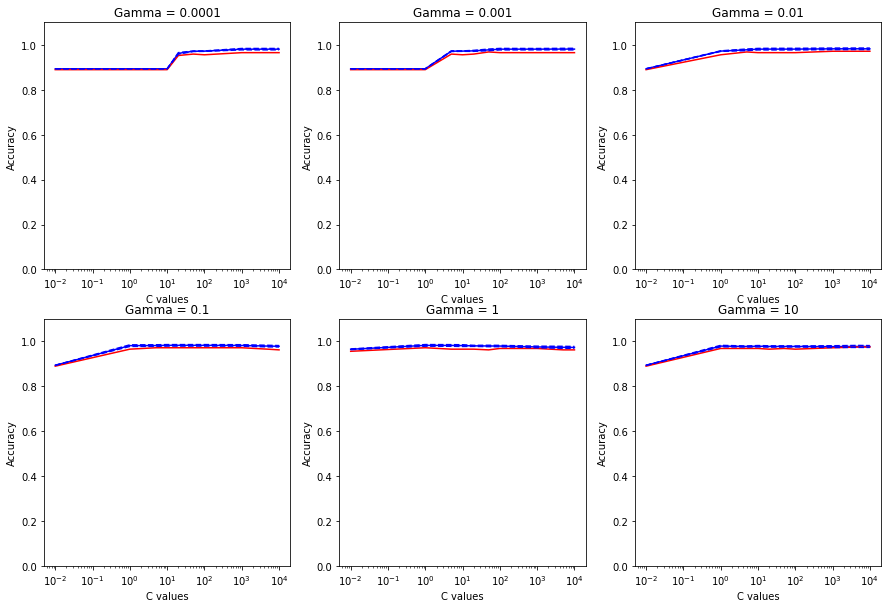

In [ ]:
c_list = [0.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000]
gamma_list = [0.0001, 0.001, 0.01, 0.1, 1, 10]

i = 0
plt.figure(figsize=(15,10))

for gamma_value in gamma_list:

  i = i + 1
  scores = list()
  score_stds = list()
  score_tests = list()

  for c_value in c_list:

    clf_cv = SVC(C=c_value, gamma=gamma_value)
    cv_score = cross_val_score(clf_cv, X_train, y_train)
    scores.append(np.mean(cv_score))
    score_stds.append(np.std(cv_score))
    clf_cv.fit(X_train, y_train)
    score_test = clf_cv.score(X_test, y_test)
    score_tests.append(score_test)

  plt.subplot(2,3,i)
  plt.semilogx(c_list, scores, 'b')
  plt.semilogx(c_list, score_tests, 'r')
  plt.semilogx(c_list, np.array(scores)+np.array(score_stds), 'b--')
  plt.semilogx(c_list, np.array(scores)+-np.array(score_stds), 'b--')
  plt.title('Gamma = {}'.format(gamma_value))
  plt.xlabel('C values')
  plt.ylabel('Accuracy')
  plt.ylim(0,1.1)

plt.show()

In [ ]:
svc_fit = SVC(C=10, gamma=1).fit(X_train, y_train)

In [ ]:
def plot_confusion_matrix(cm, classes,normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
pred_test = svc_fit.predict(X_test)
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       282
           1       0.80      0.91      0.85        35

    accuracy                           0.97       317
   macro avg       0.89      0.94      0.92       317
weighted avg       0.97      0.97      0.97       317



Normalized confusion matrix


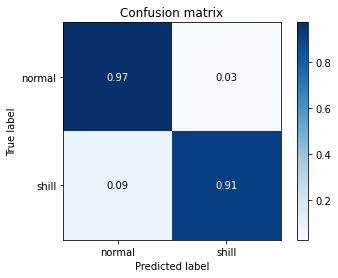

In [ ]:
cm_test_SVM = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm_test_SVM, ['normal','shill'], normalize=True)

**Observation:** Once labeled, supervised learning can easily reach an accurate prediction. However, If we examine the precision of shill bidder prediction, the value is 0.8, and is obviously lower than that of prediction of normal bidder. This should be another evidence that the shill bidder usually has a very same features with normal bidders, and it is challenging to distinguish a shill bidder from many normal bidders.

In [ ]:
### Using my label for prediction test

In [ ]:
data2a = data2[data2['class_3set']!=2]
X_1 = data2a[['Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding', 'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding', 'Winning_Ratio']]
y_1 = data2a['class_set']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, y_1, test_size=0.05, random_state=42)

In [ ]:
svc_fit1 = SVC(C=10, gamma=1).fit(X_train1, y_train1)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       211
           1       0.94      0.83      0.88        18

    accuracy                           0.98       229
   macro avg       0.96      0.91      0.94       229
weighted avg       0.98      0.98      0.98       229

Normalized confusion matrix


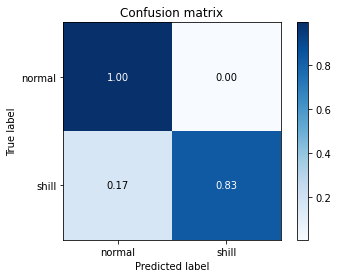

In [ ]:
pred_test1 = svc_fit1.predict(X_test1)
print(classification_report(y_test1, pred_test1))
cm_test_SVM1 = confusion_matrix(y_test1, pred_test1)
plot_confusion_matrix(cm_test_SVM1, ['normal','shill'], normalize=True)

**Observation:** The prediction performance is identical to that using ground truth. We can see that the accuracy to predict normal bidder is very high. So we may use this model to predict the normal bidder of the suspicious group so we may shrink size the suspicious group.

In [ ]:
data2b = data2[data2['class_3set']==2]
X_2 = data2b[['Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding', 'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding', 'Winning_Ratio']]

In [ ]:
pred_test2 = svc_fit1.predict(X_2)

In [ ]:
np.unique(pred_test2, return_counts=True)

(array([0, 1]), array([1554,  199]))

**Observation:** Based on the prediction results, we could be able to detect another **1554** normal bidders. However, it should be challenging to evaluate the prediction.

#7. Final results

###Total **9 % (569/6321)** records are recognized as shill bidding after combining unsupervised clustering (370/6321) and supervised classification (199/6321).